# Goal

Prevent a credit card fraud: when a bad actor uses someone else's credit card information to make a purchase without their permission.

**Columns**:
- **distance_from_home** - the distance from home where the transaction happened.
- **distance_from_last_transaction** - the distance from last transaction happened.
- **ratio_to_median_purchase_price** - Ratio of purchased price transaction to median purchase price.
- **repeat_retailer** - Is the transaction happened from same retailer.
- **used_chip** - Is the transaction through chip (credit card).
- **used_pin_number** - Is the transaction happened by using PIN number.
- **online_order** - Is the transaction an online order.
- **fraud** - Is the transaction fraudulent. This is what we're trying to predict.

# Imports

## libraries

In [57]:
# number crunching
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# validation
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Export our model
import pickle


In [58]:
# Pip 21.3+ is required
!pip install xgboost protobuf

In [59]:
from xgboost import XGBClassifier 

## data

In [60]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

---

# Exploratory Data Analysis 

## General

In [61]:
train.shape, test.shape

((18000, 9), (2000, 8))

In [62]:
train.isnull().sum()

id                                0
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [63]:
test.isnull().sum()

id                                0
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
dtype: int64

In [64]:
train

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0
2,19872,5.740898,0.167525,3.969652,1.0,0.0,0.0,1.0,0
3,18763,4.098570,0.291850,0.084129,1.0,1.0,0.0,1.0,1
4,13547,7.539580,0.294439,2.890880,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
17995,11193,8.191938,0.295913,1.011287,1.0,0.0,0.0,1.0,0
17996,10245,10.098491,1.042468,3.073815,1.0,0.0,0.0,1.0,0
17997,5660,2.826653,0.093371,0.047923,1.0,1.0,0.0,0.0,0
17998,10839,0.826856,0.164881,2.827485,0.0,0.0,0.0,1.0,0


In [65]:
train_index = len(train)-1
test_index = len(train)
train_index, test_index

(17999, 18000)

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18000 non-null  int64  
 1   distance_from_home              18000 non-null  float64
 2   distance_from_last_transaction  18000 non-null  float64
 3   ratio_to_median_purchase_price  18000 non-null  float64
 4   repeat_retailer                 18000 non-null  float64
 5   used_chip                       18000 non-null  float64
 6   used_pin_number                 18000 non-null  float64
 7   online_order                    18000 non-null  float64
 8   fraud                           18000 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.2 MB


In [67]:
train.describe()

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000
mean,10004.217000,9.634483,1.194058,1.098892,0.928556,0.294222,0.047611,0.701222,0.086000
std,5777.289102,9.635835,2.642941,1.272369,0.257789,0.458379,0.220384,0.457735,0.280372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5017.750000,2.924786,0.144539,0.335077,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9994.500000,6.181911,0.436769,0.764678,1.000000,0.000000,0.000000,1.000000,0.000000
75%,15005.250000,12.882383,1.073838,1.420102,1.000000,1.000000,0.000000,1.000000,0.000000
max,19999.000000,62.099289,51.653566,28.341698,2.000000,7.000000,8.000000,1.000000,1.000000


### distance from home

In [68]:
train.distance_from_home.nunique()

17993

In [69]:
train.distance_from_home.unique()

array([ 3.34686958, 14.48286751,  5.74089849, ...,  2.8266535 ,
        0.82685643,  3.7350089 ])

In [70]:
train.distance_from_home.value_counts()

distance_from_home
0.000000     4
8.000000     2
3.000000     2
1.000000     2
7.000000     2
            ..
16.937881    1
5.743241     1
2.686027     1
1.403830     1
3.735009     1
Name: count, Length: 17993, dtype: int64

/Users/budd8y/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='distance_from_home', ylabel='Count'>

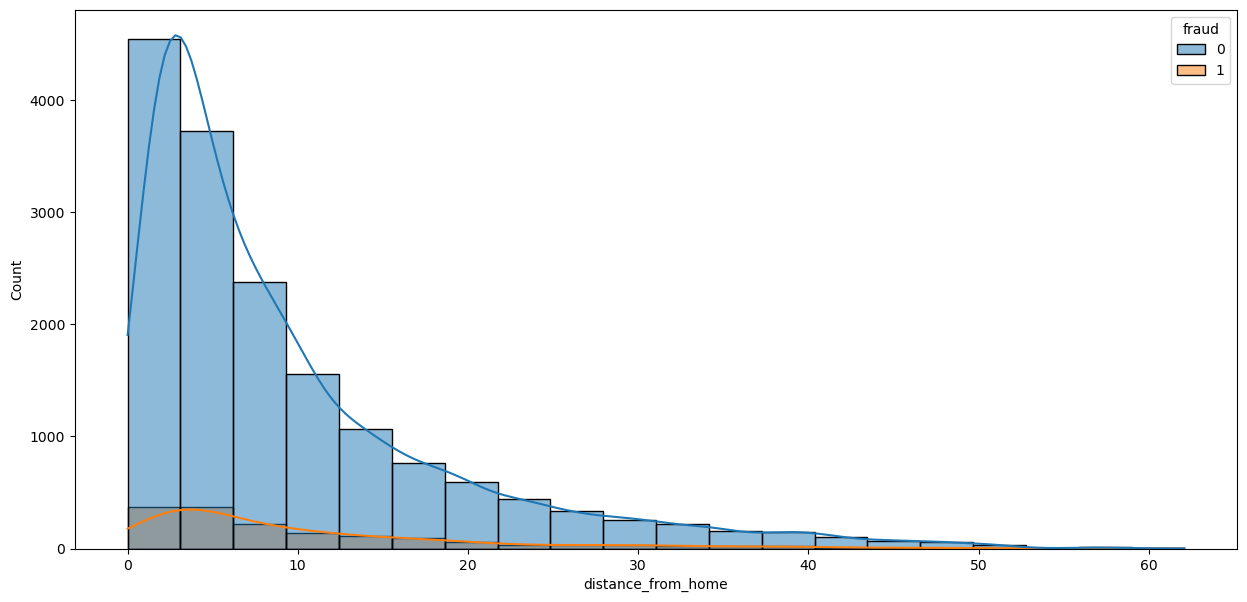

In [71]:
plt.figure(figsize=(15,7))
sns.histplot(train, bins=20, x="distance_from_home", hue="fraud", kde=True)

### my opinion
I can be wrong but for me look like that the amount of fraude is tight to amount of transaction. In other words, even though the great amount of fraud is next to the home of the person we also can see that is the greatest amount of transaction as well.

### distance_from_last_transaction

In [72]:
train.distance_from_last_transaction.nunique()

17965

/Users/budd8y/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


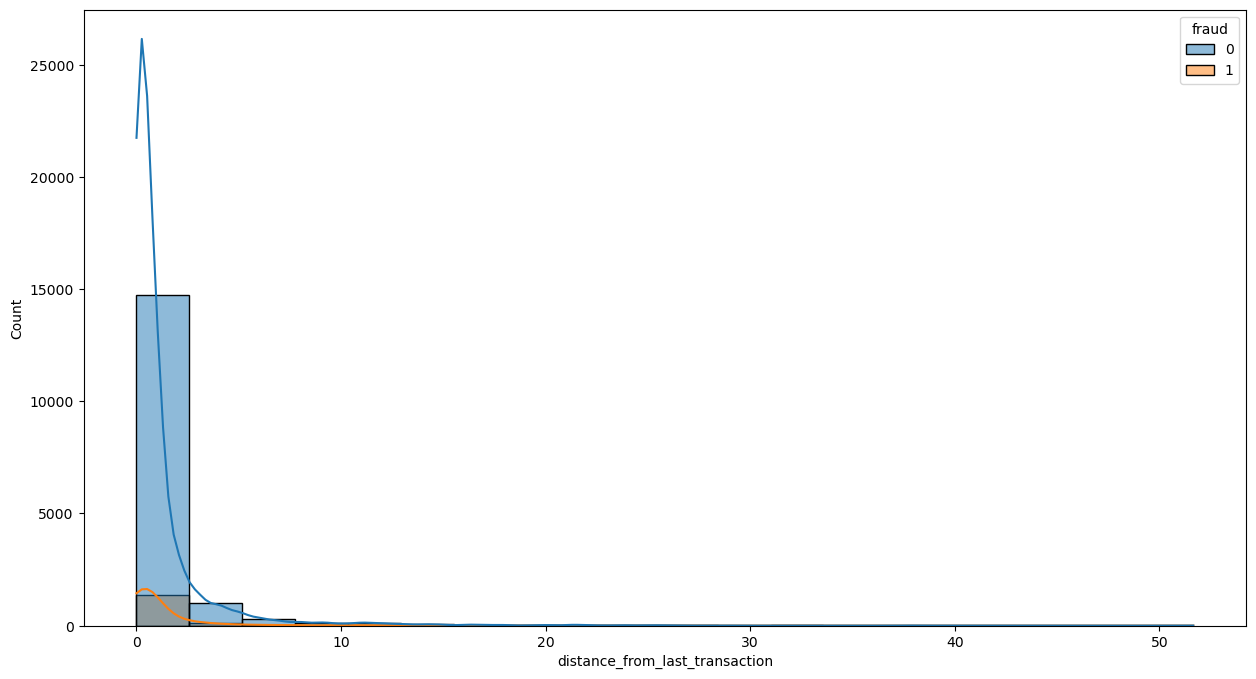

In [73]:
plt.figure(figsize=(15,8))
sns.histplot(train, x="distance_from_last_transaction", hue="fraud", kde=True, bins=20);

### my opinion
The same as the distance_from_home column

### ratio_to_median_purchase_price

In [74]:
train.head(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0


In [75]:
train.ratio_to_median_purchase_price.nunique()

17981

/Users/budd8y/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ratio_to_median_purchase_price', ylabel='Count'>

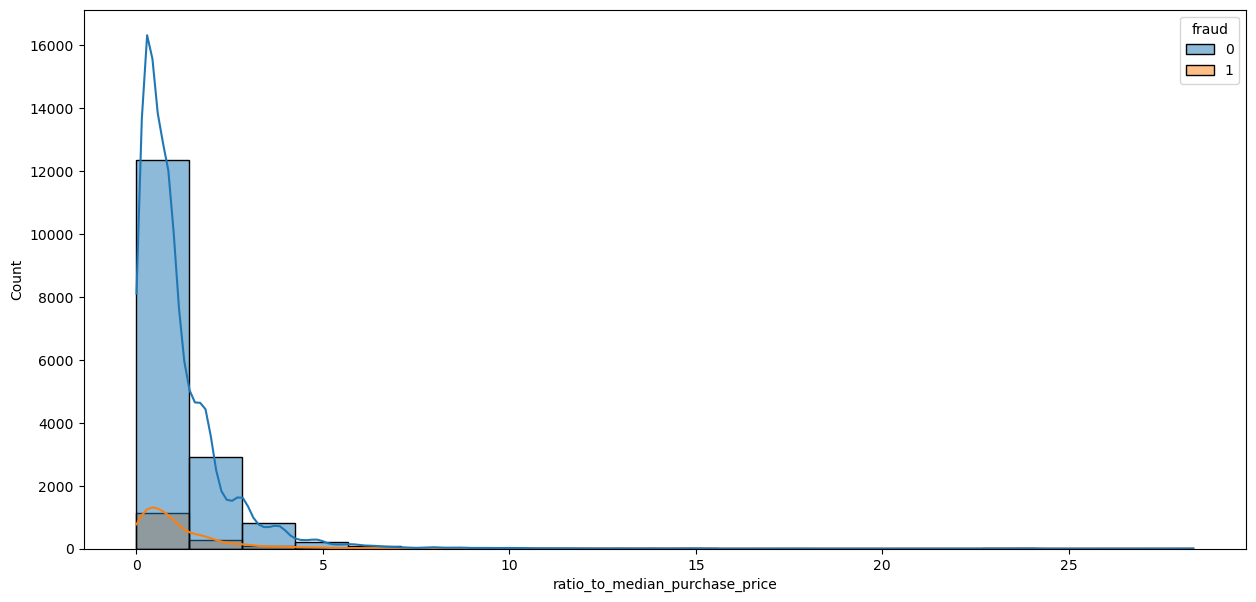

In [76]:
plt.figure(figsize=(15,7))
sns.histplot(train, x="ratio_to_median_purchase_price", kde=True, bins=20, hue="fraud")

In [77]:
train.ratio_to_median_purchase_price.duplicated().value_counts()

ratio_to_median_purchase_price
False    17981
True        19
Name: count, dtype: int64

### my opinion
the same as the distance_from_home column

### repeat_retailer

In [78]:
train.head(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0


<Axes: xlabel='repeat_retailer', ylabel='count'>

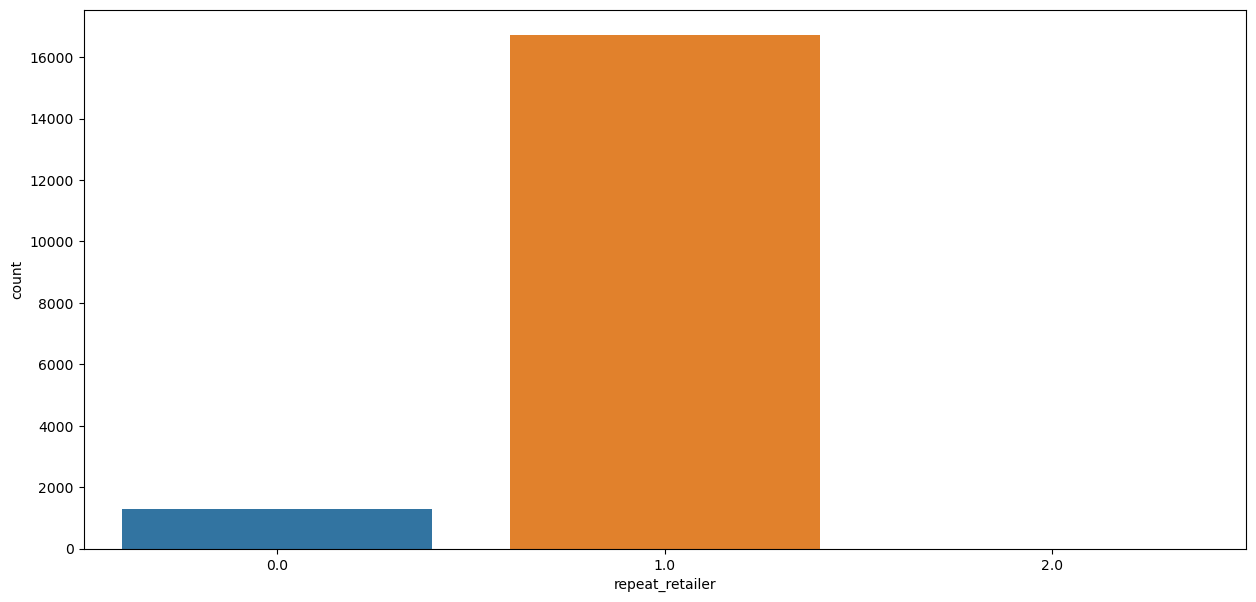

In [79]:
plt.figure(figsize=(15,7))
sns.countplot(train, x="repeat_retailer")

### my opinion
Im not sure what this numbers 0, 1, and 2 are in this column. I need to find a way to interpret this. for now let keep moving. 

### used_chip

In [80]:
train.tail(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
17998,10839,0.826856,0.164881,2.827485,0.0,0.0,0.0,1.0,0
17999,5820,3.735009,0.067014,0.241356,1.0,0.0,0.0,1.0,0


<Axes: xlabel='used_chip', ylabel='count'>

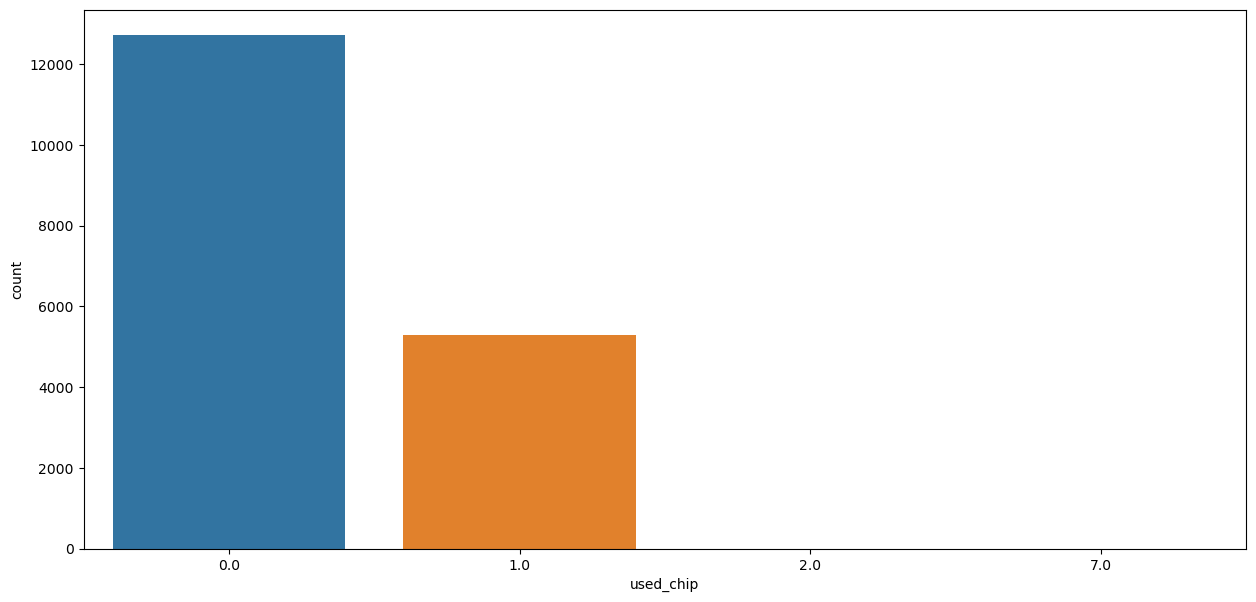

In [81]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(train, x="used_chip")

### my opinion
The more the client uses credit card with chip the more fraud are

In [82]:
train.head(2)

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0


### used_pin_number

<Axes: xlabel='used_pin_number', ylabel='count'>

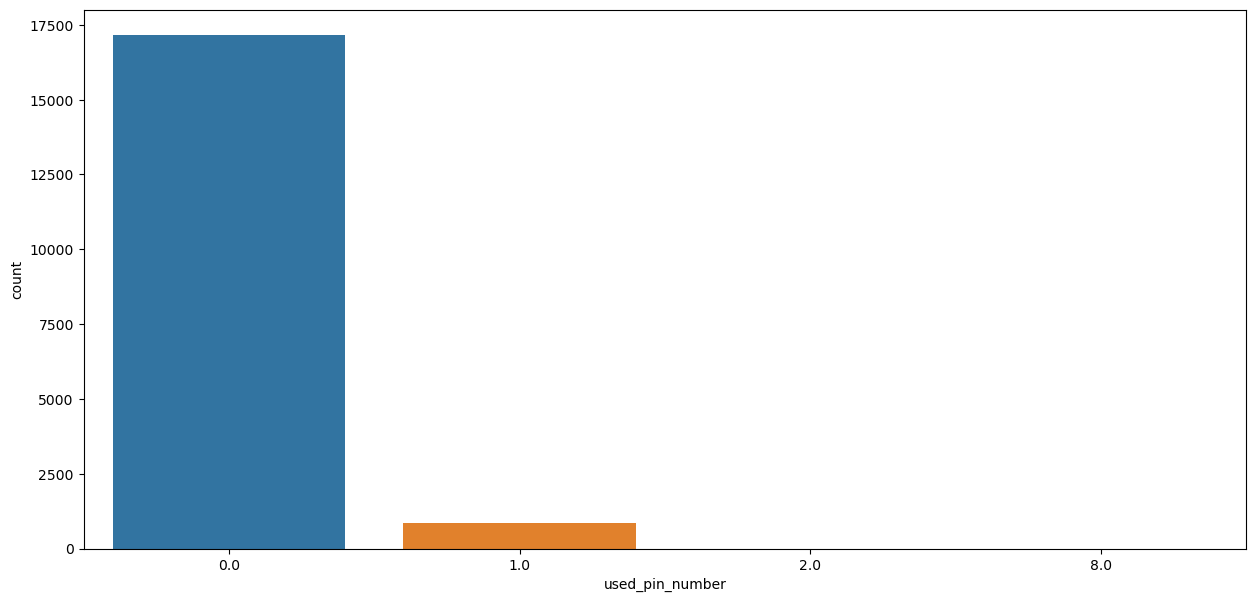

In [84]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.countplot(train, x="used_pin_number")

### my opinion
I can't see any pattern so far

### online_order

<Axes: xlabel='online_order', ylabel='count'>

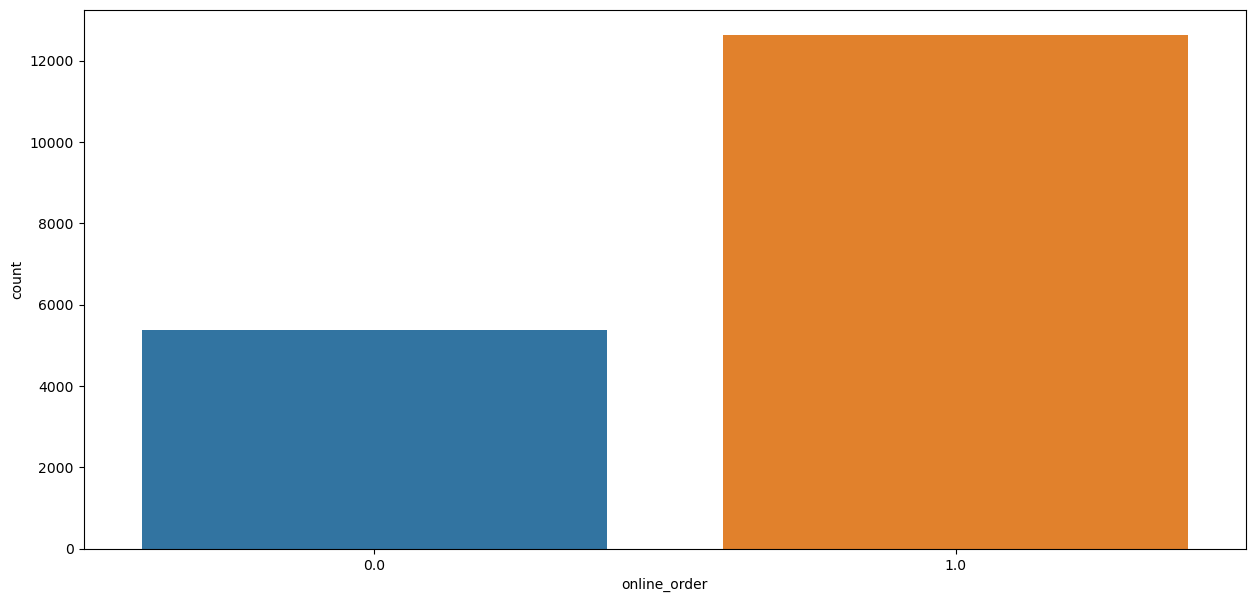

In [86]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(train, x="online_order")

### my opinion
Any pattern so far for all columns

# Data does not need preprocessing 

## split train and test data

In [125]:
data = train.drop(["id", "fraud"], axis=1)
label = train.fraud

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

# Create the Models

## Auxiliary Functions

In [126]:
def show_result(acc, text="Accuracy Score"):
    # print accuracy
    print(f"{text}: {round(acc * 100, 2)}%")
    
def real_result(value):
    return round(value * 100, 2)

def show_final_results(final_results):
    print("===Final Results===")
    for k, v in final_results.items():
        print(f"Result: {v} - Model: {k}")

## Auxiliary Variables

In [127]:
global_results = {}

## Naive Bayes

In [128]:
# Create the Model
naive = GaussianNB()

# Training
naive.fit(X_train, y_train)

# Predicting with test data
naive_pred = naive.predict(X_test)

In [129]:
# Accuracy score
acc_score = accuracy_score(y_test, naive_pred)

# print accuracy
show_result(acc_score)

Accuracy Score: 90.28%


In [130]:
# Confusion Matrix with Test data
confusion_matrix(y_test, naive_pred)

array([[3247,   52],
       [ 298,    3]])

In [131]:
# Prediction with train data
naive_pred_train = naive.predict(X_train)

# Accuracy Score
acc_score = accuracy_score(y_train, naive_pred_train)

show_result(acc_score)

Accuracy Score: 90.17%


In [132]:
# Confusion Matrix with Train data
confusion_matrix(y_train, naive_pred_train)

array([[12958,   195],
       [ 1220,    27]])

In [133]:
# Split data in folds
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross validation
model = GaussianNB()
result = cross_val_score(model, data, label, cv=kfold)

show_result(acc=result.mean(), text="Mean accuracy")

Mean accuracy: 90.52%


In [100]:
# adding final result to global results
global_results['naive_bayes'] = real_result(result.mean())

## SGDClassifier

In [134]:
transformer = ColumnTransformer([
    ('scaler', StandardScaler(), 
        ["distance_from_home", 
        "distance_from_last_transaction", 
        "ratio_to_median_purchase_price"])
])

In [135]:
# Creating a pipeline
sgd_pipeline = Pipeline(steps=[
    ('transformer', transformer),
    ('classifier', SGDClassifier(max_iter=1000))
])

# Training
sgd_pipeline.fit(X_train, y_train)

# Predict
sgd_pred = sgd_pipeline.predict(X_test)

In [136]:
# Accuracy Score
acc_score = accuracy_score(y_test, sgd_pred)

show_result(acc_score)

Accuracy Score: 91.64%


In [137]:
# Adding result to global_results
global_results['sgd'] = real_result(result.mean())

In [138]:
# Split data in folds
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross validation
result = cross_val_score(sgd_pipeline, data, label, cv=kfold)

# Result
show_result(acc=result.mean(), text="Mean accuracy")

Mean accuracy: 91.4%


## Logistic Regression

In [140]:
# Defining our model
logistic = LogisticRegression(random_state=1, max_iter=1000)

# Training
logistic.fit(X_train, y_train)

# Predict
logistic_pred = logistic.predict(X_test)

In [141]:
# Accuracy Score
acc_score = accuracy_score(y_test, logistic_pred)

# Show
show_result(acc_score)

Accuracy Score: 91.64%


In [142]:
# Split the data in folds
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross validation
model = LogisticRegression(random_state=1, max_iter=1000)
result = cross_val_score(model, data, label, cv = kfold)

# Show
show_result(acc=result.mean(), text="Mean accuracy")


Mean accuracy: 91.4%


In [143]:
# adding result to global_results
global_results['logistic_regression'] = real_result(result.mean())

## KNeighborsClassifier    

In [110]:
# Defining our model
knn = KNeighborsClassifier(n_neighbors=10)

# Training
knn.fit(X_train, y_train)

# Predict
knn_pred = knn.predict(X_test)

In [111]:
# Accuracy Score
acc_score = accuracy_score(y_test, knn_pred)

# Show
show_result(acc_score)

Accuracy Score: 90.81%


In [112]:
# Split the data in folds
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross validation
model = KNeighborsClassifier(n_neighbors=10)
result = cross_val_score(model, data, label, cv = kfold)

# Show
show_result(acc=result.mean(), text="Mean accuracy")

Mean accuracy: 91.4%


In [113]:
# Adding result to global_results
global_results['knn'] = real_result(result.mean())

## Decision Tree

In [114]:
# defining our model
decision = DecisionTreeClassifier()

# Training
decision.fit(X_train, y_train)

# Predict
decision_pred = decision.predict(X_test)

In [115]:
# Accuracy Score
acc_score = accuracy_score(y_test, decision_pred)

# Show
show_result(acc_score)

Accuracy Score: 83.39%


In [116]:
# Split our data in folders
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross validation
model = DecisionTreeClassifier()
result = cross_val_score(model, data, label, cv = kfold)

# Show
show_result(acc=result.mean(), text="Mean accuracy")

Mean accuracy: 83.19%


In [117]:
# adding result to global_results
global_results['decision'] = real_result(result.mean())
global_results

{'naive_bayes': 90.57,
 'sgd': 90.57,
 'logistic_regression': 91.4,
 'knn': 91.4,
 'decision': 83.19}

## Random Forest

In [118]:
# defining our model
randomf = RandomForestClassifier(max_depth=2, random_state=0)

# training
randomf.fit(X_train, y_train)

# predict
randomf_pred = randomf.predict(X_test)

# Accuracy Score
acc_score_f = accuracy_score(y_test, randomf_pred)

# Show Accuracy Score
show_result(acc_score_f)

Accuracy Score: 90.81%


In [119]:
# split our data in folders
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross Validation
model = RandomForestClassifier(max_depth=2, random_state=0)
result = cross_val_score(model, data, label, cv = kfold)

# Show result
show_result(acc=result.mean(), text="Mean accuracy")

KeyboardInterrupt: 

In [ ]:
# adding result to global_results
global_results['random_forest'] = real_result(result.mean())
global_results

## XGBOOST

In [ ]:
# Definin our model
xg = XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=100, objective='binary:logistic', random_state=3)

# training
xg.fit(X_train, y_train)

# predict
xg_pred = xg.predict(X_test)

# Accuracy Score
acc_score_xg = accuracy_score(y_test, xg_pred)

# Show Accuracy Score
show_result(acc_score_xg)

In [ ]:
# Split our data in folders
kfold = KFold(n_splits=30, shuffle=True, random_state=5)

# Cross Validation
model = XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=100, objective='binary:logistic', random_state=3)
result = cross_val_score(model, data, label, cv = kfold)

# Show 
show_result(acc=result.mean(), text="Mean accuracy")

In [ ]:
# adding to global_results
global_results['xgboost'] = real_result(result.mean())

# show the final result
show_final_results(global_results)

# Saving model

In [ ]:
# with open('classifier_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [146]:
# Defining our model
model = LogisticRegression(random_state=1, max_iter=10000)

# Training
model.fit(X_train, y_train)

with open('model.pkl', 'wb') as f:
    pickle.dump(logistic, f)

In [145]:
X_train

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
2721,6.847444,1.486039,0.443740,1.0,0.0,0.0,0.0
5598,2.794749,11.827583,0.288827,1.0,0.0,0.0,1.0
11711,4.839080,0.343814,0.929096,1.0,0.0,0.0,0.0
17267,25.591399,0.076393,4.415909,1.0,0.0,0.0,1.0
15480,13.458941,0.073639,0.378927,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
4234,25.922106,3.092777,0.239727,1.0,0.0,0.0,1.0
12167,4.828344,0.048088,0.189824,1.0,0.0,0.0,1.0
13204,8.723946,0.094816,0.828890,1.0,0.0,0.0,1.0
13784,26.764640,0.036938,0.448938,1.0,1.0,0.0,1.0
